In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
import tifffile as tiff 
import pickle
from pathlib import Path
from skimage import io
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import re

## Functions

In [ ]:
def result_csv_no_crop_to_table(table_path,start):
    df_deep = pd.read_csv(r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_no_crop\Results_D2_1_start_3_2022-09-06_20-48-14\centroids.csv')
    df_d = df_deep.drop(columns = 'Unnamed: 0').fillna("A")
    # re.findall("\d+\.\d+",x)
    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
    rx = re.compile(numeric_const_pattern, re.VERBOSE)
    df_d = df_d.applymap(lambda x: [float(i) for i in rx.findall(x)])
    df_d = df_d.applymap(lambda y: np.nan if len(y)<2 else y)
    df_u = df_d.unstack().reset_index()
    df_u.dropna(inplace=True)
    df_u['X'] = df_u[0].map(lambda x : x[1])
    df_u['Y'] = df_u[0].map(lambda x : x[0])
    df_u['level_0'] = df_u['level_0'].map(lambda x: int(x)+4)
    df_f = df_u.rename(columns={'level_0':'Time','level_1':'ID'}).drop(columns=0)  


In [76]:
def result_csv_to_table(table_path,start,crop, even = True):
    table_name = table_path.stem
    if table_name == 'res_all_features':
        return
    df_deep = pd.read_csv(table_path)
    df_length = df_deep.shape[1]
    crop_dict = {0:(0,0),1:(0,520),2:(704,0),3:(704,520)}
    #TODO Check it out
    df_d = df_deep.drop(columns = 'Unnamed: 0', errors='ignore').fillna("A")
    # re.findall("\d+\.\d+",x)
    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
    rx = re.compile(numeric_const_pattern, re.VERBOSE)
    df_d = df_d.applymap(lambda x: [float(i) for i in rx.findall(x)])
    df_d = df_d.applymap(lambda y: np.nan if len(y)<2 else y)
    df_u = df_d.unstack().reset_index()
    df_u.dropna(inplace=True)
    if even:
        pass
    else:
        df_u['level_0'] = df_u['level_0'].map(lambda x: int(x)+start+1)
    # TODO Add crop data
    if table_name =='centroids':
        x_add, y_add = crop_dict[crop]
        df_u['X'] = df_u[0].map(lambda x :x_add + x[1])
        df_u['Y'] = df_u[0].map(lambda x : y_add + x[0])
    elif table_name == 'embeddings':
        df_u['Embeddings'] = df_u[0]
    elif table_name == 'morphologies':
        df_u['Area'] = df_u[0].map(lambda x : x[0])
        df_u['Major Axis'] = df_u[0].map(lambda x : x[1])
        df_u['Minor Axis'] = df_u[0].map(lambda x : x[2])
    else:
        return
    df_f = df_u.rename(columns={'level_0':'Time','level_1':'ID'}).drop(columns=0)  
    return df_f

In [77]:
def folder_result_to_one_table(res_path:Path , even=True):
    res_name = res_path.stem
    res_well = res_name.split('_')[1]
    res_view = res_name.split('_')[2]
    res_start = int(res_name.split('start_')[1][0])
    res_crop = int(res_name.split('crop_')[1][0])
    df = pd.DataFrame()
    for res_csv in res_path.glob('*.csv'):
        df_res = result_csv_to_table(res_csv,res_start,res_crop,even)
        if df_res is None:
            continue
        df_res = df_res.set_index(['Time','ID'])
        df = pd.concat([df_res,df], axis=1)
    df['well'] = res_well
    df['view'] = res_view
    return df

## TIF Loading

In [18]:
tif_path = Path(r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\TIF')
tif_files = list(tif_path.glob('*.tif'))
well_dict = {}
for tif_file in tif_files:
    file_name = tif_file.stem.split('_')
    well_name = file_name[2]
    view_name = file_name[3]
    
    if well_name not in well_dict:
        well_dict[well_name] = {}
    if view_name not in well_dict[well_name]:
        well_dict[well_name][view_name] = []

    well_dict[well_name][view_name].append(tif_file)

for well, views in well_dict.items():
    for view , view_tif in views.items():
        print(f'well:{well} , view:{view}, {len(view_tif)}')

well:D2 , view:1, 95
well:D2 , view:2, 95
well:D2 , view:3, 95
well:D2 , view:4, 95
well:D3 , view:1, 95
well:D3 , view:2, 95
well:D3 , view:3, 95
well:D3 , view:4, 95
well:D4 , view:1, 95
well:D4 , view:2, 95
well:D4 , view:3, 95
well:D4 , view:4, 95
well:D5 , view:1, 95
well:D5 , view:2, 95
well:D5 , view:3, 95
well:D5 , view:4, 95
well:D6 , view:1, 95
well:D6 , view:2, 95
well:D6 , view:3, 95
well:D6 , view:4, 95
well:D7 , view:1, 95
well:D7 , view:2, 95
well:D7 , view:3, 95
well:D7 , view:4, 95
well:E10 , view:1, 95
well:E10 , view:2, 95
well:E10 , view:3, 95
well:E10 , view:4, 95
well:E2 , view:1, 95
well:E2 , view:2, 95
well:E2 , view:3, 95
well:E2 , view:4, 95
well:E3 , view:1, 95
well:E3 , view:2, 95
well:E3 , view:3, 95
well:E3 , view:4, 95
well:E4 , view:1, 95
well:E4 , view:2, 95
well:E4 , view:3, 95
well:E4 , view:4, 95
well:E5 , view:1, 95
well:E5 , view:2, 95
well:E5 , view:3, 95
well:E5 , view:4, 95
well:E6 , view:1, 95
well:E6 , view:2, 95
well:E6 , view:3, 95
well:E6 ,

## Comparision by well-view 

In [20]:
well = 'D2'
view = '1'

In [21]:
tif_arr = well_dict[well][view]

In [43]:
df_f

,Time,ID,X,Y
0,4,0,1219.91160,511.938780
1,4,1,1363.96030,516.634950
2,4,2,637.21124,573.176100
3,4,3,305.45456,761.787900
4,4,4,310.00000,774.865840
...,...,...,...,...
124747,95,1351,596.74690,1021.623500
124748,95,1352,1400.64280,1031.968300
124749,95,1353,1274.18820,853.529400
124750,95,1354,1357.57300,492.668550


In [78]:
all_res_path = Path(r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new')
for res_folder in all_res_path.glob('*'):
    print(res_folder)
    folder_result_to_one_table(res_folder, even = False).to_csv(res_folder.joinpath('res_all_features.csv'))


C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new\Results_D2_1_start_3_crop_1_2022-09-06_18-26-14
C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new\Results_D2_1_start_3_crop_2_2022-09-06_18-29-13
C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new\Results_D2_1_start_3_crop_3_2022-09-06_18-33-24
C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new\Results_D2_1_start_5_crop_0_2022-09-06_18-24-25


### DeepCell

In [79]:
all_res_path = Path(r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new')

crop_list = []
df = pd.DataFrame()
for crop_path in list(all_res_path.glob(f'*{well}_{view}*')):
    if list(crop_path.glob('*all_features.csv')):
        results_path = list(crop_path.glob('*all_features.csv'))[0]
    else:
        print('continued')
        continue
    df_c = pd.read_csv(results_path)
    df_c = df_c.drop(columns=['well','view','Embeddings','Area','Major Axis','Minor Axis'])
    crop_list.append(df_c)

df_deep = pd.concat(crop_list,axis=0,ignore_index=True)
df_deep


,Time,ID,X,Y
0,4,0,637.211240,573.176056
1,4,1,305.454560,761.787870
2,4,2,310.000000,774.865860
3,5,0,644.365000,576.744526
4,6,3,637.825200,544.496504
...,...,...,...,...
40927,95,87,620.571400,383.552800
40928,95,88,579.534500,433.206900
40929,95,89,702.333300,470.571440
40930,95,90,690.632300,474.963230


In [83]:
df_f

,Time,ID,X,Y
0,4,0,1219.91160,511.938780
1,4,1,1363.96030,516.634950
2,4,2,637.21124,573.176100
3,4,3,305.45456,761.787900
4,4,4,310.00000,774.865840
...,...,...,...,...
124747,95,1351,596.74690,1021.623500
124748,95,1352,1400.64280,1031.968300
124749,95,1353,1274.18820,853.529400
124750,95,1354,1357.57300,492.668550


In [49]:
deep_cord_f = {}
for df in df_f.groupby('Time'):
    frame_time = df[0]
    df_frame = df[1]
    cord_list = []
    for _ , row in df_frame.iterrows():
        cord_list.append([row['X'],row['Y']])
    deep_cord_f[frame_time] = cord_list
# deep_cord

In [80]:
deep_cord = {}
for df in df_deep.groupby('Time'):
    frame_time = df[0]
    df_frame = df[1]
    cord_list = []
    for _ , row in df_frame.iterrows():
        cord_list.append([row['X'],row['Y']])
    deep_cord[frame_time] = cord_list
# deep_cord

### Imaris


In [25]:
imaris_path =f'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Excel\C-2_MK001_{well}_P{view}.xls'
df_imaris = pd.read_excel(imaris_path,sheet_name="Center of Homogeneous Mass")
df_imaris

,Center of Homogeneous Mass X,Center of Homogeneous Mass Y,Center of Homogeneous Mass Z,Unit,Category,Collection,Time,Parent,ID
0,1525.618042,622.179993,0.620,um,Surface,Center of Homogeneous Mass,1,1000000000,0
1,1525.618042,622.179993,0.620,um,Surface,Center of Homogeneous Mass,2,1000000000,1
2,1525.618042,622.179993,0.620,um,Surface,Center of Homogeneous Mass,4,1000000000,2
3,1525.618042,622.179993,0.620,um,Surface,Center of Homogeneous Mass,5,1000000000,3
4,219.942001,373.575012,0.620,um,Surface,Center of Homogeneous Mass,6,1000000001,4
...,...,...,...,...,...,...,...,...,...
26659,1717.541016,1036.458984,0.620,um,Surface,Center of Homogeneous Mass,94,1000003708,26037
26660,1717.974976,1037.053955,0.621,um,Surface,Center of Homogeneous Mass,95,1000003708,26638
26661,1736.603027,1075.810059,0.620,um,Surface,Center of Homogeneous Mass,93,1000003709,25438
26662,1737.904053,1070.292969,0.620,um,Surface,Center of Homogeneous Mass,94,1000003709,26054


In [27]:
cord_imaris = {}
for df in df_imaris.groupby('Time'):
    frame_time = df[0]
    df_frame = df[1]
    cord_list = []
    for _ , row in df_frame.iterrows():
        cord_list.append([row['Center of Homogeneous Mass X'],row['Center of Homogeneous Mass Y']])
    cord_imaris[frame_time] = cord_list
cord_imaris

{1: [[1525.6180419921875, 622.1799926757812]],
 2: [[1525.6180419921875, 622.1799926757812]],
 4: [[1525.6180419921875, 622.1799926757812]],
 5: [[1525.6180419921875, 622.1799926757812]],
 6: [[219.94200134277344, 373.57501220703125],
  [382.43798828125, 892.0479736328125],
  [395.0989990234375, 908.3790283203125],
  [793.927978515625, 663.1179809570312],
  [908.1690063476562, 620.6599731445312],
  [941.0139770507812, 1079.6240234375],
  [1419.2249755859375, 865.6370239257812],
  [1445.9549560546875, 804.3740234375],
  [1498.864990234375, 8.24899959564209],
  [1516.762939453125, 581.4910278320312],
  [1524.1390380859375, 16.788999557495117],
  [1687.4859619140625, 597.948974609375]],
 7: [[380.9490051269531, 888.0570068359375],
  [401.10101318359375, 904.875],
  [797.9569702148438, 660.2760009765625],
  [909.2000122070312, 624.3189697265625],
  [942.719970703125, 1074.281005859375],
  [1420.093994140625, 864.6690063476562],
  [1450.3790283203125, 814.3060302734375],
  [1495.2900390625,

### Visual Inspection

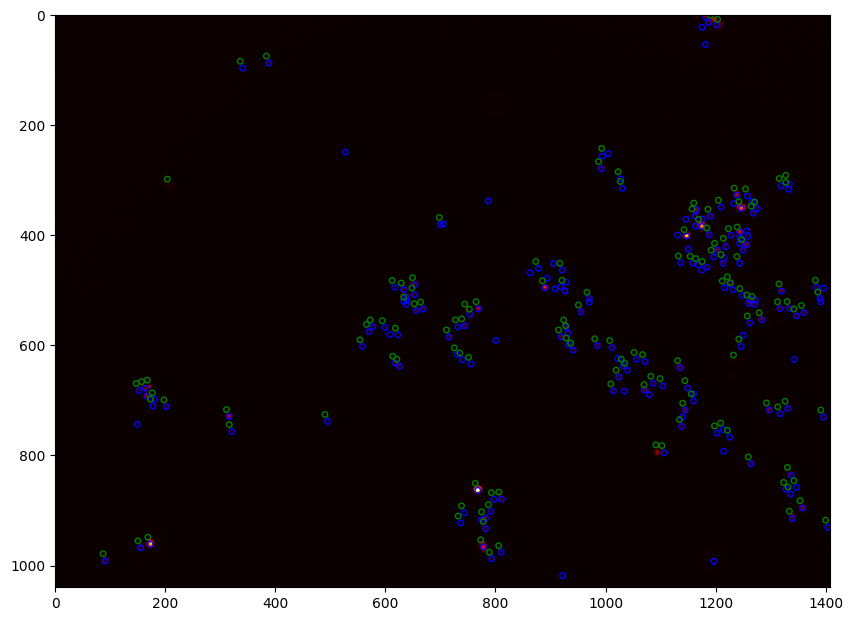

In [81]:
i = 30
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(tif_arr[i-1]), cmap = 'hot')
d_cord = deep_cord[i]
imaris_cord = cord_imaris[i]

for item in d_cord:
    ax.add_patch(plt.Circle((item[0],item[1]), 5, color='b',fill=False))
for item in imaris_cord:
    ax.add_patch(plt.Circle((item[0]/1.24,item[1]/1.24), 5, color='g',fill=False))


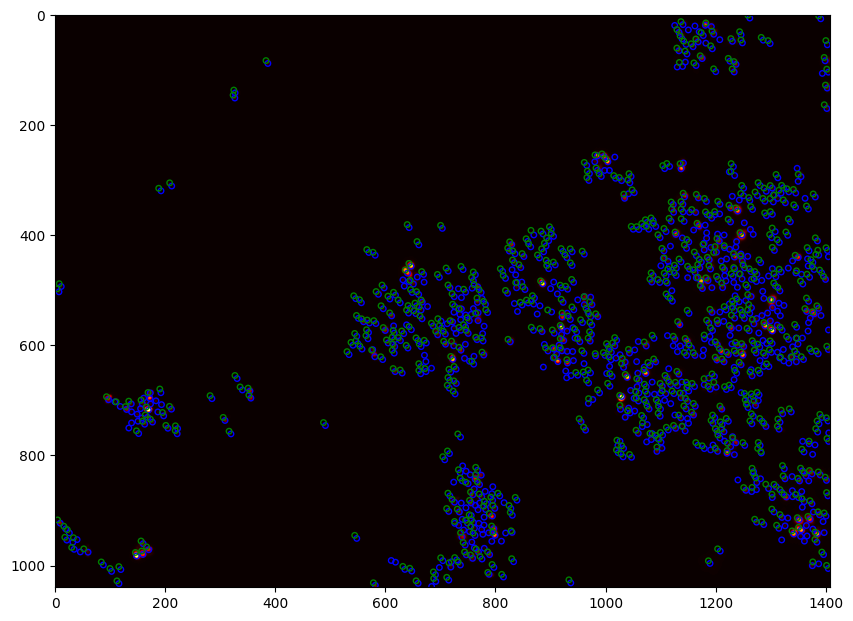

In [85]:
i = 90
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(tif_arr[i-1]), cmap = 'hot')
d_cord = deep_cord_f[i]
imaris_cord = cord_imaris[i]

for item in d_cord:
    ax.add_patch(plt.Circle((item[0],item[1]), 5, color='b',fill=False))
for item in imaris_cord:
    ax.add_patch(plt.Circle((item[0]/1.24,item[1]/1.24), 5, color='g',fill=False))
